# Assignment 7: Bagging and Boosting

Only use the already imported library `numpy`, `matplotlib` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`). Make sure that the dataset `titanic.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

==> *Write*
* *names* Srinivas Kumar Ramdas, Benedikt Riegel, Fozan Gill 
* *matr. nr.* 3513675, 3568633, 3437081
* *study program* Computer Science, Computer Science, Computer Science
* *B.Sc./M.Sc.* M.Sc., M.Sc, M.Sc

*of all assignment group participants here. (double klick here to edit)*

In [147]:
# You are allowed to use the numpy package and the DecisionTreeClassifier.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


def load_dataset(path):

    df = pd.read_csv('titanic.csv')
    # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
    # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
    df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # We map the Title attribute to a one-hot encoding.
    df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

    
    # We map the Sex attribute to a numeric representation.
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    
    # We one-hot encode Pclass.
    df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

    
    # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
    # we can determine whether a passenger was on board alone.
    df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

    
    # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
    df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

    
    # For remaining features, we have to separate train and test, 
    # as we will impute missing data based on statistics in the training data.
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
    # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
    def impute_embarked():    
        freq_port = df_train['Embarked'].dropna().mode()[0]
        output = []
        for df in (df_train, df_test):
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
            df = df.drop('Embarked', axis=1)
            output.append(df)
        return output

    df_train, df_test = impute_embarked()

    # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
    guess_ages = np.zeros((2, 3))
    for df in (df_train, df_test):
        for i in range(2):
            for j in range(3):
                guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
        for i in range(2):
            for j in range(3):
                df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
        df['Age'] = df['Age'].astype(int)

    df_train = df_train.drop(['Pclass'], axis=1)
    df_test = df_test.drop(['Pclass'], axis=1)

    X_train = df_train.values[:, 1:]
    X_test = df_test.values[:, 1:]
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset('titanic.csv')

The Titanic dataset and a description can be found at [Kaggle](https://www.kaggle.com/c/titanic/data). The feature engineering mostly follows the work by [Manav Segal](https://www.kaggle.com/startupsci/titanic-data-science-solutions). 

The prepared dataset contains the following attributes:
- Sex: binary (0 = Male, 1 = Female)
- Age: integer
- Fare: float
- Title_{Master, Miss, Mr, Mrs, Rare}: title of passenger (extracted from name), binary, one-hot encoding of categorical variable Title
- Pclass_{1, 2, 3}: ticket class corresponds to socio-economic status (1 = upper class, 2 = middle class, 3 = lower class), binary, one-hot encoding of categorical variable Pclass
- IsAlone: whether the passenger has no siblings/spouses/parents/children on board, binary
- Embarked_{C, Q, S}: port at which passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton), binary, one-hot encoding of categorical variable Embarked

The classification target is:
- Survived: binary

Data is split into train-test with a 80-20 ratio yielding 712 training and 179 test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Task 1: Random Forest (40 Points)

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be weighted equally in the majority vote. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose. 


In [148]:
class RandomForestClassifier(object):

    def __init__(self, number_of_trees, num_attributes=6, debug=False):
        self.num_attributes = num_attributes
        self.number_of_trees = number_of_trees
        self.debug = debug
        # Add your code, such as initialization of trees here.
        self.trees = [None]*number_of_trees
        for i in range(number_of_trees):
            self.trees[i] = [DecisionTreeClassifier(), []]


    def sample_data(self, X, y, amount):
        indices = np.arange(len(X))
        np.random.shuffle(indices)

        sample_i = indices[:int(amount*len(indices))]
        sample_X = [None]*len(sample_i)
        sample_y = [None]*len(sample_i)

        for i in range(len(sample_i)):
            sample_X[i] = X[sample_i[i]]
            sample_y[i] = y[sample_i[i]]

        return np.array(sample_X), np.array(sample_y)


    def random_attributes(self, X, num_att_keep):
        to_keep = np.arange(X.shape[1])
        np.random.shuffle(to_keep)
        to_keep = to_keep[:num_att_keep]
        to_keep = sorted(to_keep)
        return to_keep


    def get_tree_X(self, X, col_idx):
        row_idx = np.arange(X.shape[0])
        tree_X = X[row_idx[:, None], col_idx]
        return tree_X


    def fit(self, X, y):
        # Implement your training here.
        for treeTuple in self.trees:
            sampled_X, sampled_y = self.sample_data(X, y, 0.5)
            treeTuple[1] = self.random_attributes(sampled_X, self.num_attributes)
            sampled_X = self.get_tree_X(sampled_X, treeTuple[1])
            treeTuple[0].fit(sampled_X, sampled_y)


    def get_tree_vote(self, tree_num, X):
        tree_tuple = self.trees[tree_num]
        vote = tree_tuple[0].predict(self.get_tree_X(X, tree_tuple[1]))
        if self.debug:
            print('tree number ' + str(tree_num) + ' gets the following tree_X:')
            print(self.get_tree_X(X, tree_tuple[1]))
        return vote


    def get_votes(self, X):
        votes = [None] * self.number_of_trees
        for i in range(len(self.trees)):
            votes[i] = self.get_tree_vote(i, X)
            if self.debug:
                print('tree ' + str(i) + ' predicted ' + str(votes[i]))
        return np.array(votes)


    def round_y_hat(self, y_hat):
        for i in range(len(y_hat)):
            if y_hat[i] < 0.5:
                y_hat[i] = 0
            elif y_hat[i] > 0.5:
                y_hat[i] = 1
            else:
                y_hat[i] = np.random.randint(0, 2)
        return y_hat

    def count_votes(self, votes):
        y_hat = votes.mean(axis=0)

        if self.debug:
            print('counted y: \n' + str(y_hat))
        return self.round_y_hat(y_hat)


    def predict(self, X):
        votes = self.get_votes(X)
        if self.debug:
            print('all votes: \n' + str(votes))
        y_hat = self.count_votes(votes)
        return y_hat


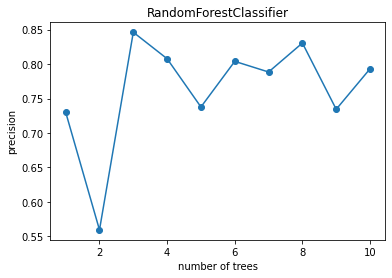

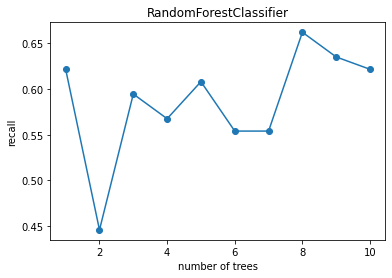

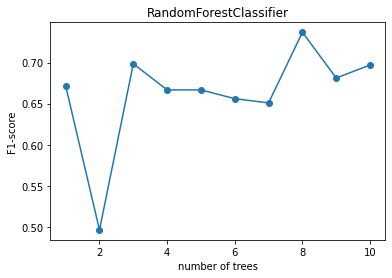

In [149]:
# Implement your training and evaluation here.
def plot_precision(num_trees, precision):
    plt.plot(num_trees, precision, marker='o')
    plt.title('RandomForestClassifier')
    plt.ylabel('precision')
    plt.xlabel('number of trees')
    plt.show()


def plot_recall(num_trees, recall):
    plt.plot(num_trees, recall, marker='o')
    plt.title('RandomForestClassifier')
    plt.ylabel('recall')
    plt.xlabel('number of trees')
    plt.show()


def plot_f1_score(num_trees, f1_score):
    plt.plot(num_trees, f1_score, marker='o')
    plt.title('RandomForestClassifier')
    plt.ylabel('F1-score')
    plt.xlabel('number of trees')
    plt.show()


def task1():
    np.random.seed(20)
    X_train, X_test, y_train, y_test = load_dataset('titanic.csv')
    num_trees = list(range(1, 11))
    precision = list()
    recall = list()
    f1_score = list()
    for i in num_trees:
        forest = RandomForestClassifier(i)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)

        precision.append(metrics.precision_score(y_test, y_hat))
        recall.append(metrics.recall_score(y_test, y_hat))
        f1_score.append(metrics.f1_score(y_test, y_hat))

    plot_precision(num_trees, precision)
    plot_recall(num_trees, recall)
    plot_f1_score(num_trees, f1_score)
    
    
task1()

## Task 2: Interpreting Random Forests (40 Points)

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyse learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

In [150]:
def create_forest():
    import sklearn.ensemble
    import sklearn.metrics
    forest = sklearn.ensemble.RandomForestClassifier(8)
    forest.fit(X_train, y_train)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_test, forest.predict(X_test))
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    return forest

forest = create_forest()

Precision: [0.76470588 0.76666667]
Recall: [0.86666667 0.62162162]
F1-score: [0.8125     0.68656716]


mda: [ 0.02723464  0.01187151  0.03840782  0.0027933   0.01606145  0.14664804
  0.04329609  0.00698324  0.02304469 -0.00139665  0.02444134  0.00628492
  0.00488827  0.00628492  0.00768156]


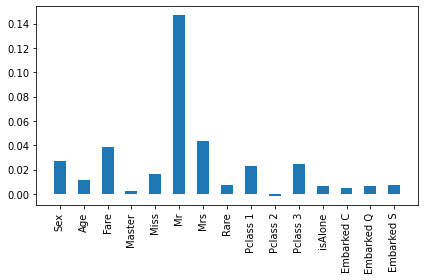

We were surprised, that sex and age aren't the most important attributes, but the title Mr can also differentiate between a person's gender, so this could be the reason why.
To see, if this is true, we have a look at the amount of people for each title and the ratio of surviving with the title Mr, vs. with another title

{'Master': 10, 'Miss': 36, 'Mr': 101, 'Mrs': 25, 'Rare': 7, 'NotMr': 78, 'Weird': 0}
survival ratio with Mr: 0.19801980198019803 and without Mr: 0.6923076923076923

As we can see we have almost as much Mr as none Mr and only 20% with the title Mr survive, while 70% with another title survive. This means the attribute Mr has a huge impact.
Therefore the attribute Mr can split the X_test dataset quite accurately.
Another suprising fact was, that age has such a low impact. Let's take a look at the titles of people of the age of 18 and younger:
{'Master': 9, 'Miss': 10, 'Mr': 5, 'Mrs': 2, 'Rare': 0, 'Weird': 0}
As we can see, we almost have no child in our test data. That 

In [151]:
# Implement your solution here.
def get_permutation(X, attribute):
    # copy X
    X_perm = np.copy(X)
    # shuffle the attribute's column
    np.random.shuffle(X_perm[:, attribute])
    return X_perm


def get_accuracy(y, y_hat):
    # accuracy is the amount of correctly predicted y's, divided by the total amount of predictions
    correct = 0
    for i in range(len(y)):
        if y[i] == y_hat[i]:
            correct += 1
    return correct/len(y)


def MDA(forest, X, y):
    # Do it for each attribute
    mda = [None]*X.shape[1]
    for attribute in range(X.shape[1]):
        # permute
        X_perm = get_permutation(X, attribute)
        da_for_attribute = [] # the decreases of accuracy for one attribute for each tree
        
        # Calc the decrease in accuracy for each tree
        for estimator in forest.estimators_:
            y_hat = estimator.predict(X)
            y_perm = estimator.predict(X_perm)

            acc_hat = get_accuracy(y, y_hat)
            acc_perm = get_accuracy(y, y_perm)
            
            #
            da_for_attribute.append(acc_hat - acc_perm)
        
        da_for_attribute = np.array(da_for_attribute)
        # compute the mean decrease in accuracy
        mda[attribute] = da_for_attribute.mean()
        
    return np.array(mda)


def task2():
    mda = MDA(forest, X_test, y_test)
    print('mda: ' + str(mda))
    attribute_names = np.array(['Sex', 'Age', 'Fare', 'Master', 'Miss', 'Mr',
                                'Mrs', 'Rare', 'Pclass 1', 'Pclass 2', 'Pclass 3',
                                'isAlone', 'Embarked C', 'Embarked Q', 'Embarked S'])
    x = np.arange(len(mda))
    plt.bar(x, mda, width=0.5)
    plt.xticks(x, attribute_names, rotation='vertical')
    plt.tight_layout()
    plt.show()
    
task2()
print('We were surprised, that sex and age aren\'t the most important attributes, but the title Mr can also differentiate between a person\'s gender, so this could be the reason why.')
print('To see, if this is true, we have a look at the amount of people for each title and the ratio of surviving with the title Mr, vs. with another title')
titles = {'Master': 0, 'Miss': 0, 'Mr': 0, 'Mrs': 0, 'Rare': 0, 'NotMr': 0, 'Weird': 0}
survival_by_title = {'Mr': 0, 'NotMr': 0}
for i in range(len(X_test)):
    x = X_test[i]
    if x[3] == 1:
        titles['Master'] += 1
        titles['NotMr'] += 1
        survival_by_title['NotMr'] += y_test[i]
    elif x[4] == 1:
        titles['Miss'] += 1
        titles['NotMr'] += 1
        survival_by_title['NotMr'] += y_test[i]
    elif x[5] == 1:
        titles['Mr'] += 1
        survival_by_title['Mr'] += y_test[i]
    elif x[6] == 1:
        titles['Mrs'] += 1
        titles['NotMr'] += 1
        survival_by_title['NotMr'] += y_test[i]
    elif x[7] == 1:
        titles['Rare'] += 1
        titles['NotMr'] += 1
        survival_by_title['NotMr'] += y_test[i]
    else:
        titles['Weird'] += 1
        titles['NotMr'] += 1
        survival_by_title['NotMr'] += y_test[i]

print()
print(titles)
print('survival ratio with Mr: ' + str(survival_by_title['Mr'] / titles['Mr']) + ' and without Mr: ' + str(survival_by_title['NotMr'] / titles['NotMr']))
print()
print('As we can see we have almost as much Mr as none Mr and only 20% with the title Mr survive, while 70% with another title survive. This means the attribute Mr has a huge impact.')
print('Therefore the attribute Mr can split the X_test dataset quite accurately.')
print('Another suprising fact was, that age has such a low impact. Let\'s take a look at the titles of people of the age of 18 and younger:')
titles = {'Master': 0, 'Miss': 0, 'Mr': 0, 'Mrs': 0, 'Rare': 0, 'Weird': 0}
for x in X_test:
    if x[1] <= 18:
        if x[3] == 1:
            titles['Master'] += 1
        elif x[4] == 1:
            titles['Miss'] += 1
        elif x[5] == 1:
            titles['Mr'] += 1
        elif x[6] == 1:
            titles['Mrs'] += 1
        elif x[7] == 1:
            titles['Rare'] += 1
        else:
            titles['Weird'] += 1

print(titles)
print('As we can see, we almost have no child in our test data. That is why we do not lose a lot of accuracy, when permuting the age attribute.')


## Task 3: Discrete AdaBoost with Decision Stumps (20 Points) - For all students other than B.Sc. Data Science 

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [152]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


class AdaBoostClassifier(object):
    def __init__(self, n_learners):
        self.n_learners = n_learners
        # Add any initialization you need here.
    
    def fit(self, X, y):
        # Implement your solution here.
        pass
    
    def predict(self, X, y):
        # Implement your solution here.
        pass


In [153]:
# Implement your training and evaluation here. You may reuse the code from Task 1.